Because I had the privilege of obtaining factory-fresh ROMs from the cameras ([as covered in the last episode](https://astrid.tech/2022/08/03/0/blink-mini-fw-analysis/)), I realized that I could use those to perform some deeper analysis of the ROM's structure. So, that's what this post will set out to do.

This post was made in a Jupyter Notebook!

## Loading and visualizing the dumps

First, we will start out by loading the dumps into our environment.

In [1]:
import numpy as np
from pathlib import Path
from os import PathLike


def read_flash_file(path: PathLike) -> np.array:
    """Loads a file as a numpy array of uint8s"""
    with Path(path).open('rb') as f:
        return np.frombuffer(f.read(), dtype=np.uint8)

flashes = Path('./flash-dumps')

# We will trim to 2 MiB because everything past that is 0xFF.
MIB = 1 << 20
old = read_flash_file(flashes / 'raw-flash.bin')[:2 * MIB]  # The original image that I got
new1 = read_flash_file(flashes / 'new1.bin')[:2 * MIB]
new2 = read_flash_file(flashes / 'new2.bin')[:2 * MIB]

Now, it's one thing to read bytes, but I personally find visualization a lot more useful. I'll use a technique somewhat similar to http://binvis.io/ to do this, but I'll emulate it in Matplotlib.

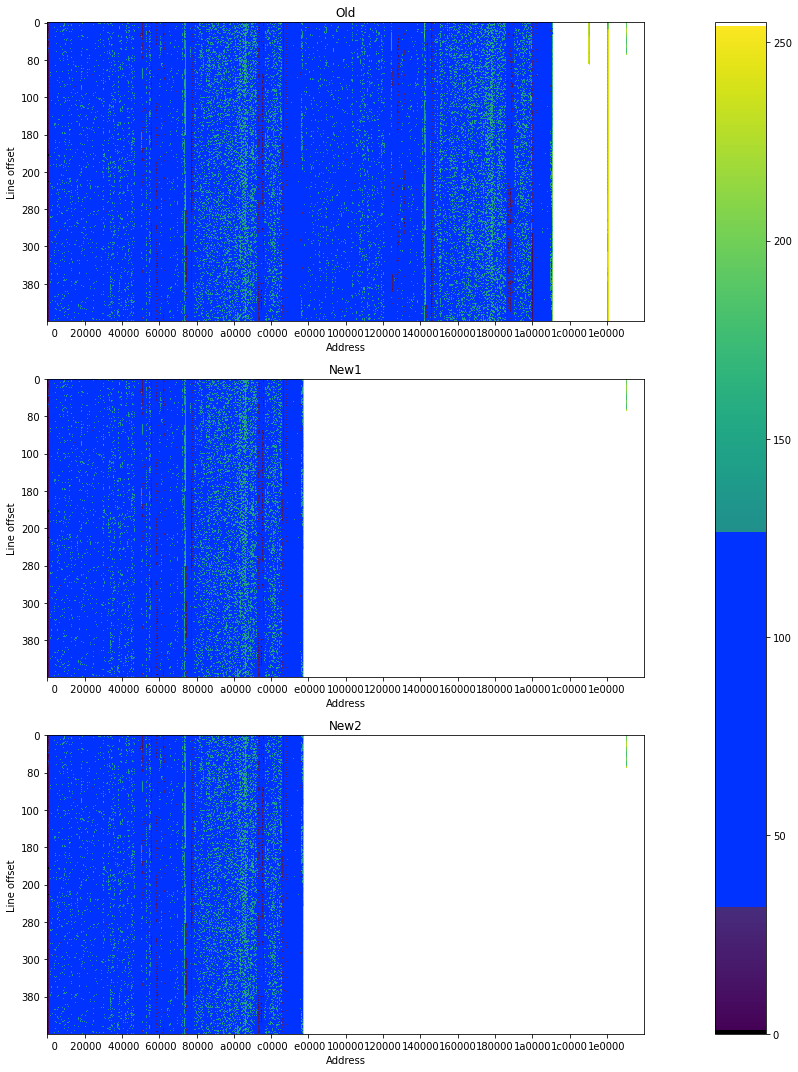

In [2]:
import math

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap


def mk_byteclass_cmap():
    """
    Inspired by the https://binvis.io/ byteclass colormap.
    
    - ZERO: 0
    - LOW: [1, 31]
    - ASCII: [32, 126]
    - HIGH: [127, 254]
    - FF: 255
    """
    base = cm.get_cmap('viridis', 256)
    
    newcolors = base(np.linspace(0, 1, 256))
    newcolors[0] = [0, 0, 0, 1]
    newcolors[32:127] = [0, .2, 1, 1]
    newcolors[255] = [1, 1, 1, 1]
    return ListedColormap(newcolors)


byteclass_cmap = mk_byteclass_cmap()


def pad_to(b: np.array, length: int, pad_val = 0) -> np.array:
    """
    Pads an array to some length.
    """
    padding_length = length - len(b)  # how much to pad by
    return np.pad(b, (0, padding_length), constant_values=pad_val)  # perform the padding



def plot_bin(b: np.array, *, ax=None, offset_tick_interval=128, line_tick_interval=128, binline_length=1024, **imshow_kwargs):
    # Pad the binary to a multiple of the binline_length
    padded_length = math.ceil(len(b) / binline_length) * binline_length  # how long we want it to be
    padded = pad_to(b, padded_length, 0)
    
    # Turn the binary into a 2D image by reshaping it.
    image = np.reshape(padded, (-1, binline_length)).T
    
    # Assemble the kwargs, and plot the binary.
    imshow_kwargs = {'cmap': byteclass_cmap, **imshow_kwargs}
    plt.imshow(image, **imshow_kwargs)
    plt.ylabel('Line offset')
    plt.xlabel('Address')
    
    # Formatting for the tickmarks.
    def fmt_slice_index(x, p):
        x = int(x) * binline_length
        return f"{x:6x}"
    
    def fmt_slice_offset(x, p):
        x = int(x)
        return f"{x:3x}"

    axes = plt.gca()
    axes.get_xaxis().set_major_locator(ticker.MultipleLocator(line_tick_interval))
    axes.get_xaxis().set_major_formatter(ticker.FuncFormatter(fmt_slice_index))
    axes.get_yaxis().set_major_locator(ticker.MultipleLocator(offset_tick_interval))
    axes.get_yaxis().set_major_formatter(ticker.FuncFormatter(fmt_slice_offset))


_, axs = plt.subplots(3, 1, figsize=(20, 15))

for title, b, ax in zip(['Old', 'New1', 'New2'], [old, new1, new2], axs):
    plt.sca(ax)
    plot_bin(b)
    plt.title(title)

plt.tight_layout()
plt.colorbar(ax=axs)
plt.show()

A couple of big things stand out right here:

- New1 and New2 look identical.
- Old's first half is extremely similar to New1 and New2.
- There is a lot of complex data up until a certain point.
- Past `0x1c0000`, it is entirely 0xFF except for a few small lines.

If you remember the A/B firmware update scheme from last post, it seems as though new firmwares only get one app image in the first half of the ROM. The old firmware was updated, so the second half is filled in with a newer firmware version.

Now, let's perform some diffs to confirm our hypotheses.

### Diffing New1 with New2

We'll first look at the differences between the two factory-fresh images to see what kind of variation they have, if at all.

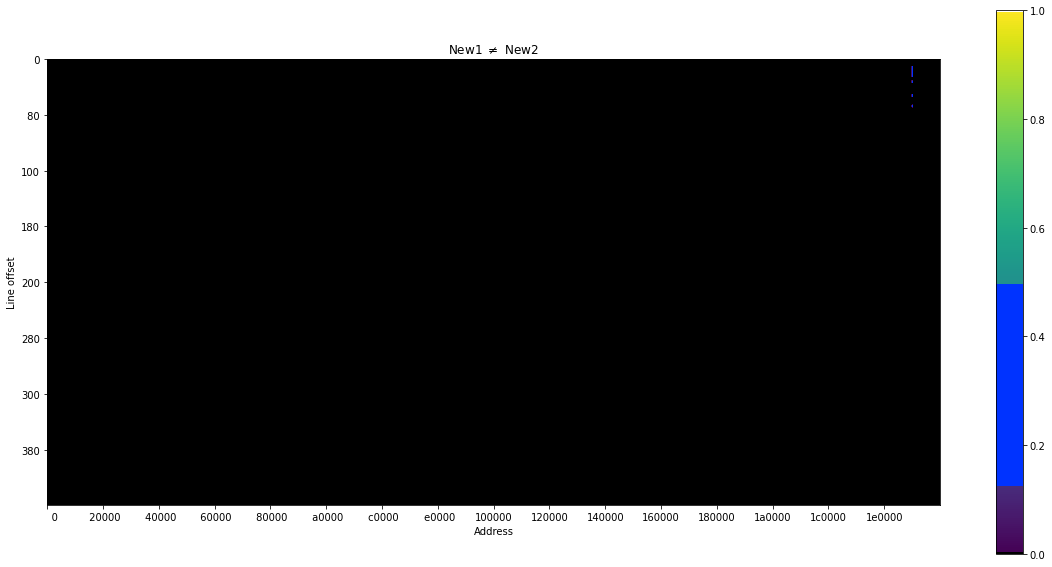

In [3]:
new1_d_new2 = (new1 != new2)

plt.figure(figsize=(20, 10))
plot_bin(new1_d_new2, vmin=0, vmax=1)
plt.title(r'New1 $\neq$ New2')

plt.colorbar()
plt.show()

Between New1 and New2, all of the data looks identical except for a tiny sliver at the end. Let's confirm this by listing all the differing bytes.

In [4]:
print(' # OFFSET  N1 N2')
print('-- ------  -- --')
n = 0
for i, (a, b) in enumerate(zip(new1, new2)):
    if a == b:
        continue
    print(f'{n:02} {i:06x}  {a:02x} {b:02x}')
    n += 1

 # OFFSET  N1 N2
-- ------  -- --
00 1f0013  46 42
01 1f0015  7c e8
02 1f0016  63 d8
03 1f0017  05 7e
04 1f0018  4a 62
05 1f0019  ca ef
06 1f001a  54 41
07 1f001b  a7 02
08 1f001c  e1 ff
09 1f001d  48 85
10 1f001e  67 63
11 1f001f  93 84
12 1f0020  46 8a
13 1f0021  a9 ce
14 1f0022  19 b6
15 1f0023  1c 92
16 1f0024  75 e6
17 1f0025  df dd
18 1f0026  8f 2a
19 1f0027  05 b9
20 1f0028  a3 25
21 1f0029  34 60
22 1f002a  4b 18
23 1f0034  38 39
24 1f0035  33 43
25 1f0036  46 37
26 1f0037  45 34
27 1f0054  38 42
28 1f0055  41 38
29 1f0056  46 42
30 1f0057  44 42
31 1f006c  c1 a3
32 1f006d  54 75
33 1f006e  17 c2
34 1f006f  e6 7e


The two binaries are almost entirely identical to each other, except for only a few bytes after `0x1f0000`. That must be where the the device-specific information region is stored, like the serial number or MAC.

That's not the only device-specific information, because it seems that the old value had a few more tiny strips of data, perhaps around `0x1c0000` or `0x1d0000`.

### Diffing Old with New

Since both of the new images are practically identical, I'll just diff old with new1.

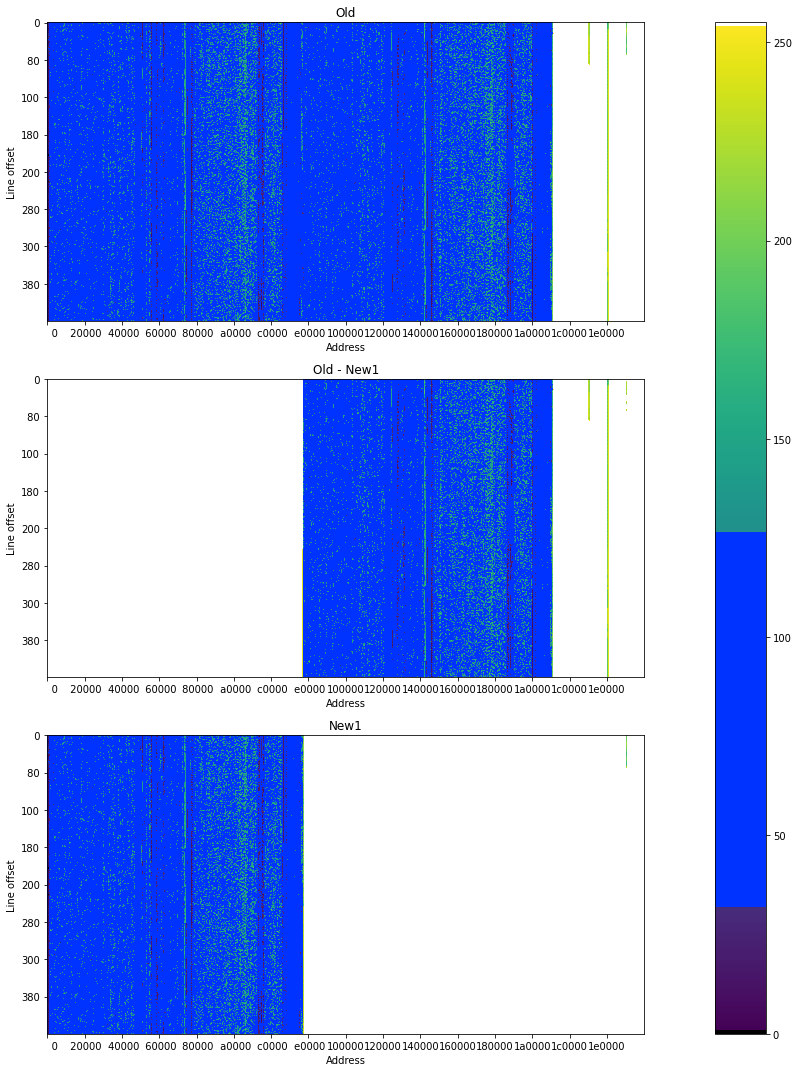

In [5]:
old_minus_new1 = old.copy()
old_minus_new1[new1 == old] = 0xff  # clear similar bytes

_, axs = plt.subplots(3, 1, figsize=(20, 15))

for title, b, ax in zip(
    ['Old', r'Old - New1', 'New1'],
    [old, old_minus_new1, new1], 
    axs
):
    plt.sca(ax)
    plot_bin(b)
    plt.title(title)

plt.tight_layout()
plt.colorbar(ax=axs)
plt.show()

Interestingly, the entire first half of the ROM looks the same! That would confirm the A/B software update hypothesis. Admittedly, I didn't update the camera more than once, but it seems to be the case that it keeps the factory ROM.

However, this is just a visualization. Are they really *completely* identical up until that midpoint?

In [6]:
for ab_border, (n, o) in enumerate(zip(new1, old)):
    if n != o:
        print(f'{ab_border} = 0x{ab_border:x}')
        break

898636 = 0xdb64c


Yes they are. So perhaps there might be a header before the first firmware, and that would mean the two headers are byte-identical too.

## Isolating the A/B apps

The other really cool thing is that this diff reveals a way for us to possibly isolate the firmware images. Let's zoom in on that border region, and look at the extent `0xdb000` to `0xdc000` to see what's there.

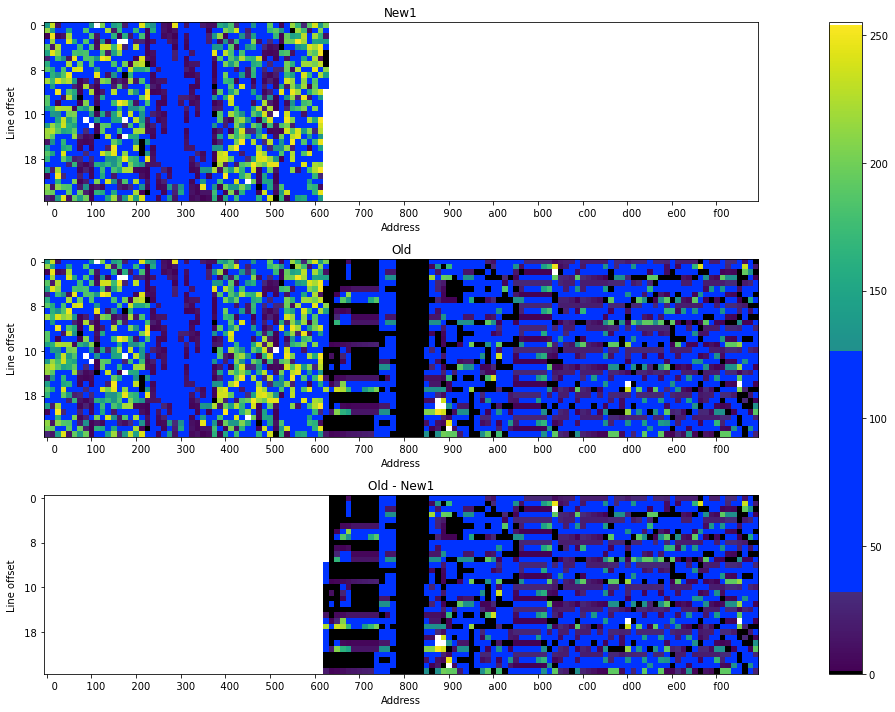

In [7]:
_, axs = plt.subplots(3, 1, figsize=(20, 10))

for title, b, ax in zip(
    ['New1', r'Old', 'Old - New1'],
    [new1[0xdb000:0xdc000], old[0xdb000: 0xdc000], old_minus_new1[0xdb000:0xdc000]], 
    axs
):
    plt.sca(ax)
    plot_bin(b, offset_tick_interval=8, line_tick_interval=8, binline_length=32)
    plt.title(title)

plt.tight_layout()
plt.colorbar(ax=axs)
plt.show()

There appears to be some fascinating structure to the images, but it might not be captured by a visualization; let's actually look at the bytes themselves.

In [8]:
from pprint import pprint

from hexdump import hexdump

prefix_of_b = old[ab_border:ab_border + 128]

pprint(bytes(prefix_of_b))
print()
hexdump(prefix_of_b)

(b'BUND\x00\x00\x00\x00\x00\rU\xe0owl \x00\x00\x00\x11\x00\x00\x00\x00'
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\t\x00J\x00\x00\x010'
 b'\x00\x00\x00\x11\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x01D'
 b'\x00\x05\x1b\xa8\x00\x00\x00\x03\x00\x00\x00\x00\x00\x05\x1c\xec'
 b'\x00\x00K\xd0\x00\x00\x00\x04\x00\x00\x00\x00\x00\x05h\xbc\x00\x01h$'
 b'\x00\x00\x00\x06 \x19\x03(\x00\x06\xd0\xe0\x00\x00\x04\xa4\x00\x00\x00\x08'
 b'\x07-bv\x00\x06\xd5\x84\x00\x06U$')

00000000: 42 55 4E 44 00 00 00 00  00 0D 55 E0 6F 77 6C 20  BUND......U.owl 
00000010: 00 00 00 11 00 00 00 00  00 00 00 00 00 00 00 00  ................
00000020: 00 00 00 01 00 09 00 4A  00 00 01 30 00 00 00 11  .......J...0....
00000030: 00 00 00 02 00 00 00 00  00 00 01 44 00 05 1B A8  ...........D....
00000040: 00 00 00 03 00 00 00 00  00 05 1C EC 00 00 4B D0  ..............K.
00000050: 00 00 00 04 00 00 00 00  00 05 68 BC 00 01 68 24  ..........h...h$
00000060: 00 00 00 06 20 19 03 28  00 06 D0 E0 00 00 04 A4  ..

### What is BUND?

When I was poking around in Ghidra earlier, I believe I encountered that BUND thing, but way earlier in the image. It looks like a [magic number](https://en.wikipedia.org/wiki/Magic_number_(programming)). I also looked it up online and there were no relevant results for it.

Is there another occurrence of it in the image?

In [9]:
bund_magic = b'BUND\0\0\0\0\0\r'

# Is there an appearance of BUND between 0 and ab_border?
bund1_offset = bytes(new1).find(bund_magic)
bund1_offset, hex(bund1_offset)

(7168, '0x1c00')

In [10]:
# Is there an appearance of BUND *after* the one at ab_border?
bund_magic in bytes(new1)[bund1_offset + 1:]

False

So there is only one other BUND, it is close to the beginning of the image, and it's at a suspiciously round offset `0x1c00`. Let's see what comes after it.

In [11]:
prefix_of_a = bytes(new1)[bund1_offset:bund1_offset + 128]

pprint(bytes(prefix_of_a))
print()
hexdump(prefix_of_a)

(b'BUND\x00\x00\x00\x00\x00\r\x9aLowl \x00\x00\x00\x11\x00\x00\x00\x00'
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\t\x00$\x00\x00\x010'
 b'\x00\x00\x00\x18\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x01H'
 b'\x00\x05\xd7\xb0\x00\x00\x00\x03\x00\x00\x00\x00\x00\x05\xd8\xf8'
 b'\x00\x00L\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x06$\xf8\x00\x01l\xf0'
 b'\x00\x00\x00\x06 \x19\x03(\x00\x07\x91\xe8\x00\x00\x04\xa4\x00\x00\x00\x08'
 b'\x07E\x98P\x00\x07\x96\x8c\x00\x05\xd8\x86')

00000000: 42 55 4E 44 00 00 00 00  00 0D 9A 4C 6F 77 6C 20  BUND.......Lowl 
00000010: 00 00 00 11 00 00 00 00  00 00 00 00 00 00 00 00  ................
00000020: 00 00 00 01 00 09 00 24  00 00 01 30 00 00 00 18  .......$...0....
00000030: 00 00 00 02 00 00 00 00  00 00 01 48 00 05 D7 B0  ...........H....
00000040: 00 00 00 03 00 00 00 00  00 05 D8 F8 00 00 4C 00  ..............L.
00000050: 00 00 00 04 00 00 00 00  00 06 24 F8 00 01 6C F0  ..........$...l.
00000060: 00 00 00 06 20 19 03 28  00 07 91 E8 00 

It looks like `prefix_of_a` is almost identical to `prefix_of_b`, which strongly suggests that our BUND string is a magic number followed by a standard header format. `'BUND\0\0\0\0\0\r'` must be the magic number for the firmware!

### Carving out BUND A and BUND B

I'll call our A/B apps BUNDs from now on because that's what they start with and it's easier to refer to them that way.

We'll find the end of BUND B by searching backwards in the image for non-0xFF values the way we did before, except we'll start our search at `0x1c0000` so that we don't get the user data segments.

In [12]:
for i in range(0x1c0000, 0, -1):
    if old[i] != 255:
        end_of_b = i + 1
        break

end_of_b, hex(end_of_b)

(1772588, '0x1b0c2c')

And now, we can easily carve out both BUNDs because we know the following things:

- BUND A starts at `bund1_offset`
- BUND B ends at `end_of_b`
- `ab_border` is the dividing line between BUND A and BUND B

BUND A length = 891468 = 0xd9a4c
BUND B length = 873952 = 0xd55e0


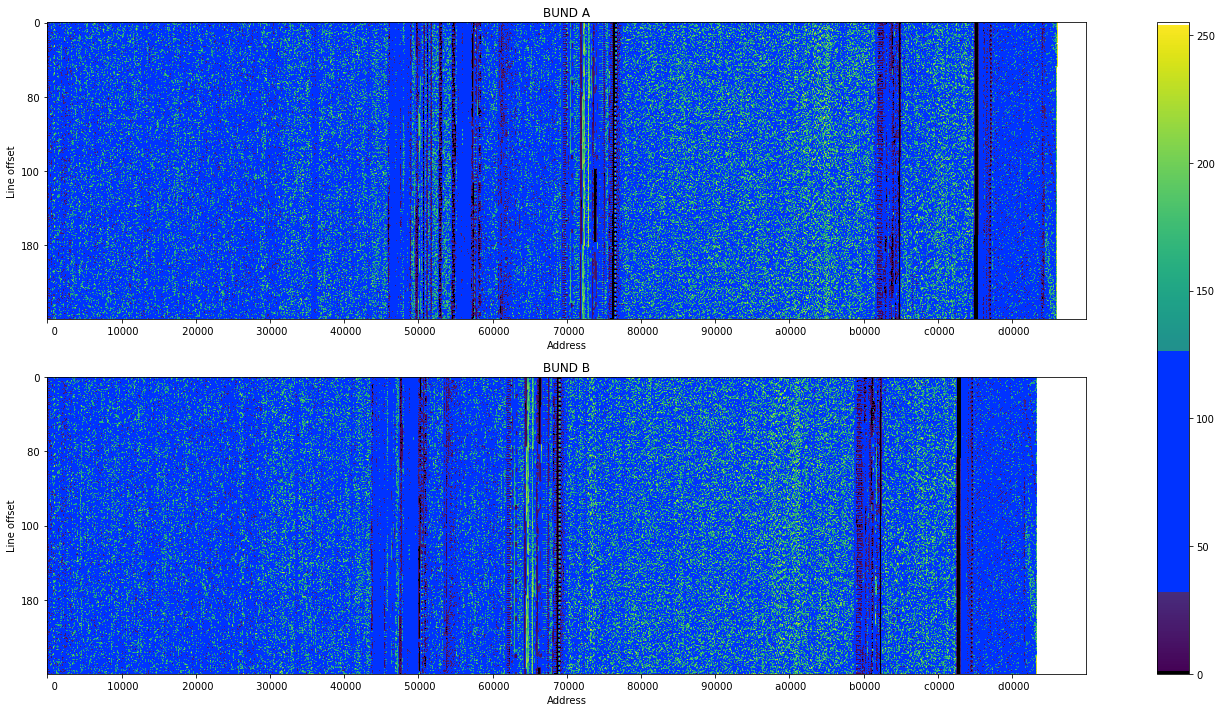

In [13]:
bund_a = old[bund1_offset:ab_border]
bund_b = old[ab_border:end_of_b]

print(f'BUND A length = {len(bund_a)} = 0x{len(bund_a):x}')
print(f'BUND B length = {len(bund_b)} = 0x{len(bund_b):x}')

_, axs = plt.subplots(2, 1, figsize=(20, 10))

pad_len = 0xe0000

for title, b, ax in zip(
    ['BUND A', 'BUND B'],
    [pad_to(bund_a, pad_len, 0xff), pad_to(bund_b, pad_len, 0xff)],
    axs
):
    plt.sca(ax)
    plot_bin(b, binline_length=512)
    plt.title(title)

plt.tight_layout()
plt.colorbar(ax=axs)
plt.show()

We now have our two carved BUNDs! If we wanted to, we could dump them to a file like so.

```python
with Path('flash-dumps/bund_a.bin').open('wb') as f:
    f.write(bytes(bund1))

with Path('flash-dumps/bund_b.bin').open('wb') as f:
    f.write(bytes(bund2))
```

Some observations:

- The two BUNDs are remarkably similar in terms of structure, which makes sense. You can see a lot of striping patterns in one that line up with the other's.
- BUND A overall seems slightly longer than BUND B, even though BUND B is ostensibly newer than BUND A. They may have optimized their code. Who knows.
- The individual regions of A are not all longer than those in B.

It would be quite interesting to overlay this with Ghidra-decompiled data, but that might be something I do another time.

### Simple diff of the BUNDs

This wasn't very useful, but I'll just leave this here for reference. A smarter diff, like the Unix one, would be much more useful because of the uneven regions of the firmware.

Total bytes in BUND A: 891468
Total bytes in BUND B: 873952
Different bytes: 868827
Same bytes: 22641
97.4603% difference


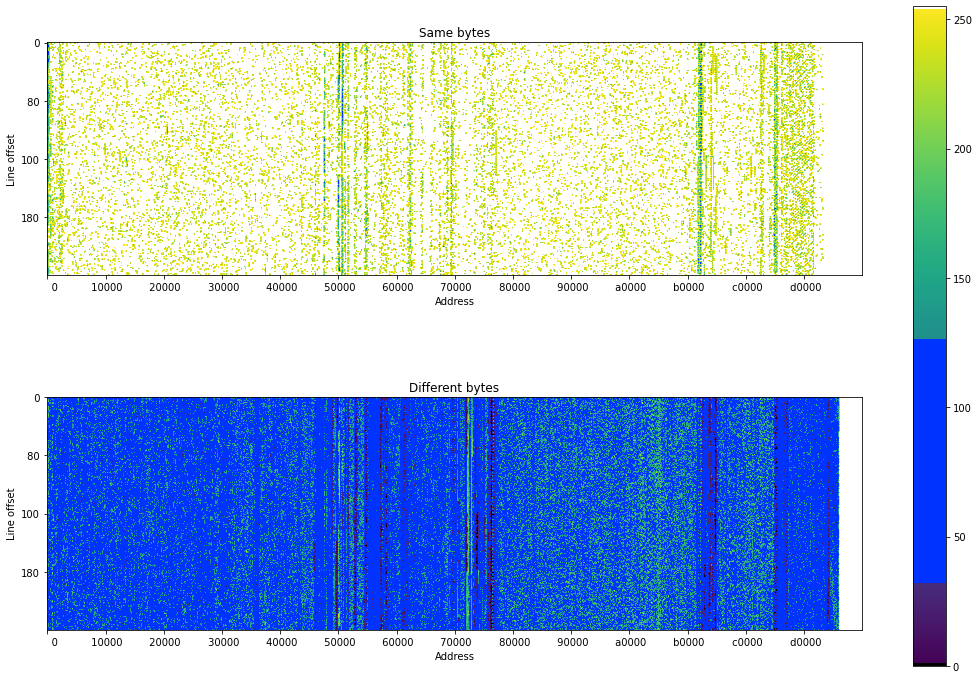

In [14]:
bund_a_pad, bund_b_pad = pad_to(bund_a, pad_len, 0xff), pad_to(bund_b, pad_len, 0xff)

bund_same = bund_a_pad.copy()
bund_same[bund_a_pad != bund_b_pad] = 0xff

bund_diff = bund_a_pad.copy()
bund_diff[bund_a_pad == bund_b_pad] = 0xff

ndiff = len(bund_a_pad[bund_a_pad != bund_b_pad])
print('Total bytes in BUND A:', len(bund_a))
print('Total bytes in BUND B:', len(bund_b))
print('Different bytes:', ndiff)
print('Same bytes:', len(bund_a) - ndiff)
print(f'{ndiff * 100 / len(bund_a):.04f}% difference')

_, axs = plt.subplots(2, 1, figsize=(15, 10))

for title, b, ax in zip(
    ['Same bytes', 'Different bytes'],
    [bund_same, bund_diff],
    axs
):
    plt.sca(ax)
    plot_bin(b, binline_length=512)
    plt.title(title)

plt.tight_layout()
plt.colorbar(ax=axs)
plt.show()

### OSINT of what the hell BUND means

I don't know anything about German, but Google seems to, and they say that "bund" has the meaning of federation, union, alliance, with the implication that it is of a political nature. Examples might include [Bundesrepublik Deutschland](https://en.wikipedia.org/wiki/Germany), [Bundeswehr](https://en.wikipedia.org/wiki/Bundeswehr), or the [German-American Bund](https://en.wikipedia.org/wiki/German_American_Bund) that was for Nazi supporters.

I googled for stuff like "BUND file format" or "BUND magic number" but nothing good came out of that, which implies that it's probably a custom or proprietary file format. Alternatively, it could be something stupid like an ELF but with `BUND\0\0\0\0\0\r` rather than `\x7FELF`.

I suspected that it could be someone's name, or multiple people's names as an acronym, but I stalked the Linkedins of [Immedia Semiconductor](https://www.linkedin.com/company/immedia-semiconductor/) and [Blink](https://www.linkedin.com/company/immedia-semiconductor/) and didn't find anything.

## Conclusion and next steps

Also, I carved out two BUNDs from the firmware. That's pretty good, and I can probably feed them into [rbasefind](https://github.com/sgayou/rbasefind) for more accurate results.

A really exciting thing, though, is [OFRAK](https://ofrak.com/), which will be released around DEFCON, and that will let me analyze this flash a lot deeper.

**TL;DR: I made pretty graphs :3 and did some binary carving >:)**